## Weibull AFT

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
import pandas as pd
from theano import tensor as T
import theano.tensor as tt
import statsmodels
import patsy
import pystan
import matplotlib.pylab as plt

/home/preich/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
dataset = statsmodels.datasets.get_rdataset(package='survival', dataname='flchain' )
d = dataset.data.query('futime > 7').sample(500)
d.reset_index(level=0, inplace=True)
d.rename(columns={'futime': 't', 'death': 'event'}, inplace=True)

In [4]:
y, x_df = patsy.dmatrices("event ~ age + sex", d, return_type='dataframe')
x_df = x_df.iloc[:, x_df.columns != 'Intercept']

N, M = x_df.shape
x = x_df.as_matrix()
y = d['t'].values
event = d['event'].values.astype(int)
d.head()

,index,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,t,event,chapter
0,5401,59,F,1996,1.40,1.34,5,1.0,0,4655,0,NaN
1,771,75,M,1996,3.23,3.61,10,1.3,0,4698,0,NaN
2,1502,71,F,1996,1.16,1.29,4,0.9,0,4837,0,NaN
3,4107,61,F,1997,2.72,2.51,10,0.9,0,4458,0,NaN
4,5355,55,F,1997,1.20,1.19,4,0.8,0,4514,0,NaN


In [5]:
sd_mu = 10.0
sd_al = 10.0


def weibull_lccdf(value, alpha, beta):
    return - (value / beta)**alpha


with pm.Model() as weibull:
    beta_raw = pm.Normal('b0', mu=0., sd=1., shape=M)
    alpha_raw = pm.Normal('a0', mu=0., sd=.1)
    mu = pm.Normal('mu', mu=0., sd=sd_mu)

    tau_s_raw = pm.HalfNormal('tau_s_raw', 10.)
    tau_raw = pm.ChiSquared('tau_raw', 1., shape=M)
    beta = pm.Deterministic('beta', tau_s_raw * tt.sqrt(1. / tau_raw) * beta_raw)

    alpha = pm.Deterministic('alpha', tt.exp(sd_al * alpha_raw))

    lp = mu + tt.dot(x, beta)

    y1 = pm.Weibull('y1', alpha, tt.exp(-(lp[event == 1]) / alpha), observed=y[event == 1])
    y0 = pm.Potential('y0', weibull_lccdf(y[event == 0], alpha, tt.exp(-(lp[event == 0]) / alpha)))

In [6]:
with weibull:
    trace = pm.sample(1000, tune=1000, init='adapt_diag',cores=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [tau_raw_log__, tau_s_raw_log__, mu, a0, b0]
INFO:pymc3:NUTS: [tau_raw_log__, tau_s_raw_log__, mu, a0, b0]
100%|██████████| 2000/2000 [03:07<00:00, 10.65it/s]
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight pro

In [7]:
time = np.asarray([59, 115, 156, 421, 431, 448, 464, 475, 477, 563, 638, 744,
                   769, 770, 803, 855, 1040, 1106, 1129, 1206, 1227, 268, 329, 353, 365, 377], dtype=np.float64)
event = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
                    0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [8]:
sd_mu = 100.0
sd_al = 10.0


def weibull_lccdf(value, alpha, beta):
    return - (value / beta)**alpha


with pm.Model() as weibull:
    alpha_raw = pm.Normal('a0', mu=0., sd=.1)
    mu = pm.Normal('mu', mu=0., sd=sd_mu)

    alpha = pm.Deterministic('alpha', tt.exp(sd_al * alpha_raw))
    beta = pm.Deterministic('beta', tt.exp(mu / alpha))
    y1 = pm.Weibull(
        'y1', alpha, beta, observed=time[event == 1])
    y0 = pm.Potential(
        'y0', weibull_lccdf(time[event == 0], alpha, beta))
    
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, a0]
INFO:pymc3:NUTS: [mu, a0]
100%|██████████| 2000/2000 [00:03<00:00, 501.04it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8975843429710121, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8909489395535494, but should be close to 0.8. Try to increase the number of tun

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd80c09f630>,
      dtype=object)

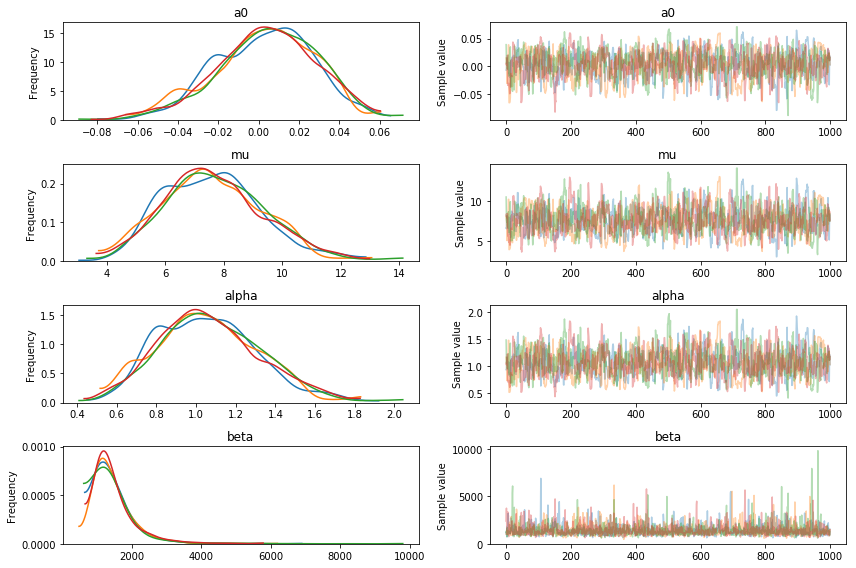

In [9]:
pm.traceplot(trace)

In [10]:
df = pm.summary(trace)
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,0.003311,0.024499,0.000893,-0.045900,0.048736,702.002823,1.000923
mu,7.642499,1.700270,0.061832,4.456919,10.872331,690.003099,1.000934
alpha,1.064396,0.254776,0.009305,0.586770,1.550909,696.651597,1.000984
beta,1457.272672,628.946871,13.946009,638.279579,2579.835456,2087.822248,0.999881


In [11]:
with pm.Model() as m:
    alpha = pm.Normal('alpha', 0., 10.)
    r = pm.Gamma('r', 1., .001, testval=.25)
    beta = pm.Deterministic('beta', tt.exp(-alpha / r))
    y1 = pm.Weibull(
        'y1', r, beta, observed=time[event == 1])
    y0 = pm.Bernoulli(
        'y0', tt.exp(-tt.pow(time[event == 0] / beta, r)),
         observed=np.ones(np.sum(event == 0)))
#     y0 = pm.Potential(
#         'y0', weibull_lccdf(time[event == 0], r, beta))


In [12]:
for var in m.basic_RVs:
    print(var.name, var.logp(m.test_point))

alpha -3.2215236261987186
r_log__ -8.294299640102027
y1 -118.12923796422496
y0 -73.75103703376016


In [13]:
with m:
    tr = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_log__, alpha]
INFO:pymc3:NUTS: [r_log__, alpha]
100%|██████████| 2000/2000 [00:03<00:00, 521.92it/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6955384779724525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences a

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7d595fef0>,
      dtype=object)

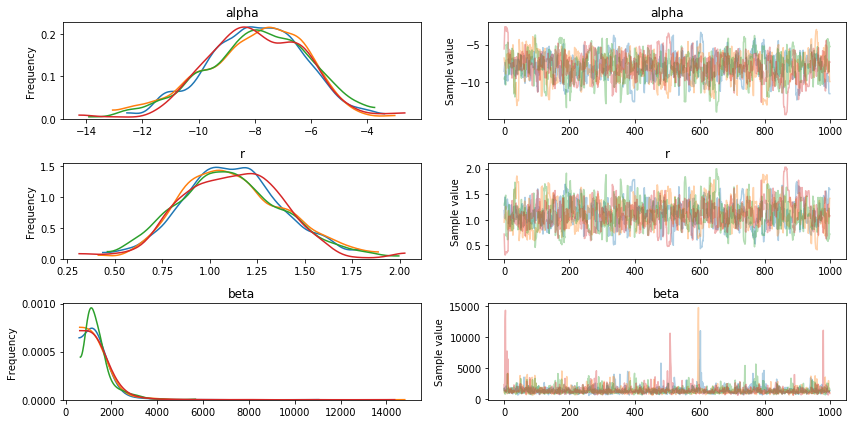

In [14]:
pm.traceplot(tr)

In [15]:
pm.summary(tr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-7.985141,1.818741,0.079400,-11.643637,-4.661755,452.866549,0.999667
r,1.117220,0.272711,0.011926,0.592614,1.648385,458.563513,0.999807
beta,1422.996907,758.773989,22.638874,668.568438,2537.009616,1114.358795,1.000742


In [16]:
logtime = np.log(time)

def gumbel_sf(y, mu, sigma):
    return 1.0 - tt.exp(-tt.exp(-(y - mu) / sigma))


# Build Bayesian model
with pm.Model() as model:
    # Hyperprior
    s = pm.HalfNormal("s", tau=5.0)

    # Priors
    gamma = pm.Normal("gamma", 0., 5.0)

    # Likelihood for uncensored and censored survival times
    y_obs = pm.Gumbel("y_obs", mu=gamma, beta=s, observed=logtime[event == 1])
    y_cens = pm.Bernoulli("y_cens", p=gumbel_sf(
        logtime[event == 0], mu=gamma, sigma=s), observed=np.ones(np.sum(event == 0)))

    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, s_log__]
INFO:pymc3:NUTS: [gamma, s_log__]
100%|██████████| 2000/2000 [00:01<00:00, 1577.30it/s]


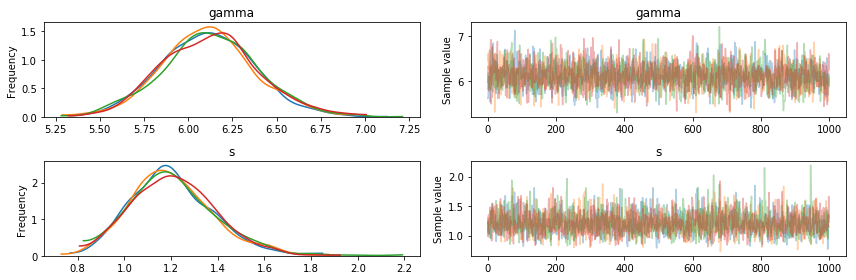

In [17]:
pm.traceplot(trace);

In [18]:
df = pm.summary(trace)
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gamma,6.117829,0.268473,0.006060,5.604131,6.665304,2119.515406,1.000106
s,1.206676,0.179582,0.003575,0.847905,1.540422,2413.830389,1.000010
